In [4]:
# Install needed packages
!pip install researchpy
!pip install openpyxl==3.0.10
!pip install statsmodels

     |████████████████████████████████| 242 kB 2.6 MB/s eta 0:00:01
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.9
    Uninstalling openpyxl-3.0.9:
      Successfully uninstalled openpyxl-3.0.9


In [1]:
# Import Packages
import pandas as pd
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load original data
df = pd.read_stata('android_xsection_treated_cleaned.dta')

# Extract labels
'''
labels = df.variable_labels()
labels = pd.DataFrame(labels,index=[0])
labels.to_excel("labels_description.xlsx")
'''
# Create a new dataset with dummy variables for further analysis
df2 = pd.get_dummies(data=df,columns = ['treatment','mobile_source','country'], drop_first=True)

In [3]:
# Split control group and treatment group
control = df[df['treatment']=='no_promo']
treatment = df[df['treatment']!='no_promo']
treatment_after0days = df[df['treatment'] == "after0days"]
treatment_after25days = df[df['treatment'] == "after25days"]
treatment_after50days = df[df['treatment'] == "after50days"]

In [4]:
# Define a function for linear regression
def lm(x,y):
    x1=sm.add_constant(x)
    model=sm.OLS(y,x1).fit()
    coef=model.params
    return model.summary() 

# Define a function for standard error
def se(x):
    n = x.count()
    sd = x.std()
    se = sd/n**0.5
    return se

## Hypothesis Testing & Further Explaination

### Long Term profits

#### Conversion

In [12]:
# t test for conversion 
conversion_t = rp.ttest(group1 = treatment['conversion'],group1_name = 'treatment_conversion',group2 = control['conversion'],group2_name = 'control_conversion')
conversion_t

(               Variable         N      Mean        SD        SE  95% Conf.  \
 0  treatment_conversion  134061.0  0.059428  0.236425  0.000646   0.058163   
 1    control_conversion   26521.0  0.043362  0.203674  0.001251   0.040910   
 2              combined  160582.0  0.056775  0.231412  0.000577   0.055643   
 
    Interval  
 0  0.060694  
 1  0.045813  
 2  0.057907  ,
                                   Independent t-test      results
 0  Difference (treatment_conversion - control_con...       0.0161
 1                              Degrees of freedom =   160580.0000
 2                                               t =       10.3340
 3                           Two side test p value =        0.0000
 4                          Difference < 0 p value =        1.0000
 5                          Difference > 0 p value =        0.0000
 6                                       Cohen's d =        0.0695
 7                                       Hedge's g =        0.0694
 8                

In [46]:
# Linear regression for conversion
lm(df2[['treatment_after25days', 'treatment_after50days',
       'treatment_no_promo']],df2['conversion'])

/Users/willawangyicheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     50.41
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           1.48e-32
Time:                        17:25:37   Log-Likelihood:                 7240.5
No. Observations:              160582   AIC:                        -1.447e+04
Df Residuals:                  160578   BIC:                        -1.443e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0644      0.001     65.217      0.000       0.062       0.066
treatment_after25days    -0.0077      0.001     -5.429      0.000      -0.010      -0.005
treatment_after50days    -0.0099      0.002     -5.711      0.000      -0.013      -0.006
treatment_no_promo       -0.0210      0.002    -12.157      0.000      -0.024      -0.018
==============================================================================
Omnibus:                   121833.117   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1462179.000
Skew:                           3.825   Prob(JB):                         0.00
Kurtosis:                      15.649   Cond. No.                         4.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

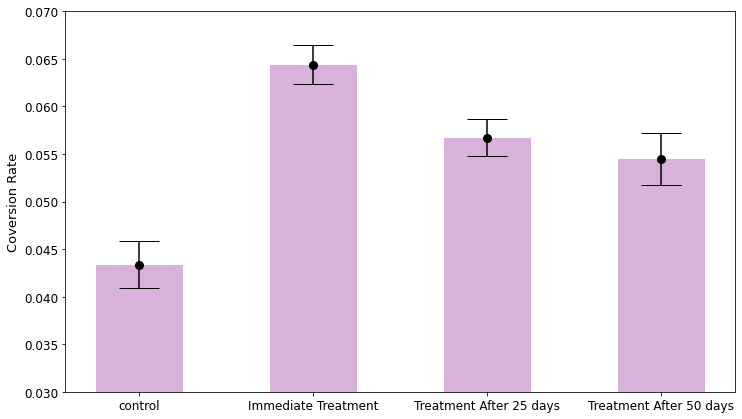

In [33]:
# Creat bar plot with error bar for conversion

# Find out sample mean
conversion_control_mean = control['conversion'].mean()
conversion_0_mean = treatment_after0days['conversion'].mean()
conversion_25_mean = treatment_after25days['conversion'].mean()
conversion_50_mean = treatment_after50days['conversion'].mean()

# Find out standard error
conversion_control_se = se(control['conversion'])
conversion_0_se = se(treatment_after0days['conversion'])
conversion_25_se = se(treatment_after25days['conversion'])
conversion_50_se = se(treatment_after50days['conversion'])


plt.figure(figsize=(12,7))
a = ["control","Immediate Treatment","Treatment After 25 days","Treatment After 50 days"]
b = [conversion_control_mean, conversion_0_mean, conversion_25_mean, conversion_50_mean]
plt.ylim(0.03,0.07)
plt.yticks(fontsize=12)
plt.ylabel("Coversion Rate",fontsize=13)
plt.xticks( fontsize=12)
plt.bar(a, b,color='purple',alpha=0.3, width=0.5)
c = [1.96 * conversion_control_se, 1.96*conversion_0_se, 1.96*conversion_25_se,1.96*conversion_50_se]
(_, caps, _) = plt.errorbar(a, b, yerr = c, color = "black",fmt = "o",markersize=8, capsize=20)
for cap in caps:
    cap.set_markeredgewidth(1)

#### Purchases 

In [13]:
# t test for purchases
purchases_t=rp.ttest(group1 = treatment['purchases'],group1_name = 'treat_purchases',
         group2 = control['purchases'],group2_name = 'control_purchases')
purchases_t

(            Variable         N      Mean        SD        SE  95% Conf.  \
 0    treat_purchases  134061.0  0.367997  3.201637  0.008744   0.350858   
 1  control_purchases   26521.0  0.289959  3.092065  0.018987   0.252744   
 2           combined  160582.0  0.355108  3.183923  0.007945   0.339536   
 
    Interval  
 0  0.385135  
 1  0.327174  
 2  0.370681  ,
                                   Independent t-test      results
 0  Difference (treat_purchases - control_purchase...       0.0780
 1                              Degrees of freedom =   160580.0000
 2                                               t =        3.6472
 3                           Two side test p value =        0.0003
 4                          Difference < 0 p value =        0.9999
 5                          Difference > 0 p value =        0.0001
 6                                       Cohen's d =        0.0245
 7                                       Hedge's g =        0.0245
 8                            

In [ ]:
# Linear regression for puchases
lm(df2[['treatment_after25days', 'treatment_after50days',
       'treatment_no_promo']],df2['purchases'])

(0.2, 0.429682691252093)

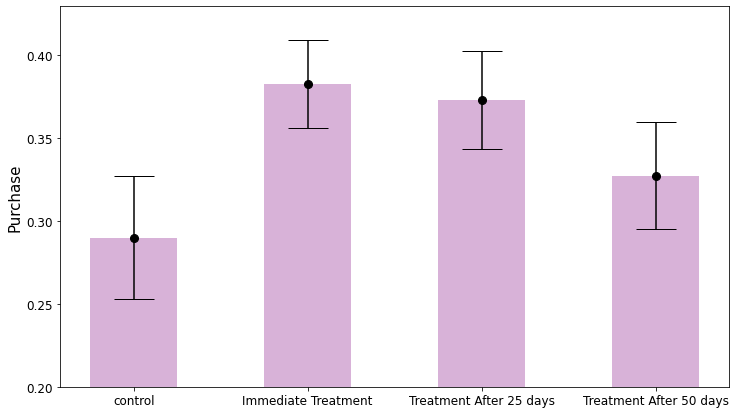

In [35]:
# Creat bar plot with error bar for conversion

# Find out sample mean
purchases_control_mean = control['purchases'].mean()
purchases_0_mean = treatment_after0days['purchases'].mean()
purchases_25_mean = treatment_after25days['purchases'].mean()
purchases_50_mean = treatment_after50days['purchases'].mean()
# Find out standard error
purchases_control_se = se(control['purchases'])
purchases_0_se = se(treatment_after0days['purchases'])
purchases_25_se = se(treatment_after25days['purchases'])
purchases_50_se = se(treatment_after50days['purchases'])

plt.figure(figsize=(12,7))
a = ["control","Immediate Treatment","Treatment After 25 days","Treatment After 50 days"]
b = [purchases_control_mean, purchases_0_mean, purchases_25_mean, purchases_50_mean]
plt.yticks(fontsize=12)
plt.ylabel("Purchase",fontsize=15)
plt.xticks( fontsize=12)
plt.bar(a, b,color='purple',alpha=0.3, width=0.5)
c = [1.96 * purchases_control_se, 1.96*purchases_0_se, 1.96*purchases_25_se,1.96*purchases_50_se]
(_, caps, _) = plt.errorbar(a, b, yerr = c, color = "black",fmt = "o",markersize=8, capsize=20)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.ylim(ymin=0.2)

#### Different Types of Revenue 

#### Revenue 

In [14]:
# t test for revenue
revenue_t = rp.ttest(group1 = treatment['revenue'], group1_name = 'treatment_revenue',
         group2 = control['revenue'],group2_name = 'control_revenue' )
revenue_t

(            Variable         N      Mean         SD        SE  95% Conf.  \
 0  treatment_revenue  134061.0  4.334119  57.145046  0.156014   4.028335   
 1    control_revenue   26521.0  3.527224  55.328819  0.339715   2.861365   
 2           combined  160582.0  4.200852  56.873009  0.141819   3.922890   
 
    Interval  
 0  4.639904  
 1  4.193083  
 2  4.478815  ,
                                   Independent t-test      results
 0  Difference (treatment_revenue - control_revenu...       0.8069
 1                              Degrees of freedom =   160580.0000
 2                                               t =        2.1126
 3                           Two side test p value =        0.0346
 4                          Difference < 0 p value =        0.9827
 5                          Difference > 0 p value =        0.0173
 6                                       Cohen's d =        0.0142
 7                                       Hedge's g =        0.0142
 8                        

In [ ]:
# Linear regression for revenue
lm(df2[['treatment_after25days', 'treatment_after50days',
       'treatment_no_promo']],df2['revenue'])

#### Shop_revenue ( non promotional revenue )

In [15]:
# t test for shop_revenue
shop_revenue_t = rp.ttest(group1 = treatment['shop_revenue'],group1_name = 'shop_revenue_treatment',
group2 = control['shop_revenue'], group2_name = 'shop_revenue_control')
shop_revenue_t

(                 Variable         N      Mean         SD        SE  95% Conf.  \
 0  shop_revenue_treatment  134061.0  3.198268  45.611679  0.124522   2.954207   
 1    shop_revenue_control   26521.0  3.527224  55.328819  0.339715   2.861365   
 2                combined  160582.0  3.252602  47.333164  0.118131   3.021069   
 
    Interval  
 0  3.442330  
 1  4.193083  
 2  3.484135  ,
                                   Independent t-test      results
 0  Difference (shop_revenue_treatment - shop_reve...      -0.3290
 1                              Degrees of freedom =   160580.0000
 2                                               t =       -1.0340
 3                           Two side test p value =        0.3011
 4                          Difference < 0 p value =        0.1506
 5                          Difference > 0 p value =        0.8494
 6                                       Cohen's d =       -0.0069
 7                                       Hedge's g =       -0.0069
 8    

#### Promo_Revenue 

In [16]:
# t test for promo_revenue
promo_revenue_t = rp.ttest(group1 = treatment['promo_revenue'], group1_name = 'treatment_promo_revenue',
group2 = control['promo_revenue'],group2_name = 'control_promo_revenue')
promo_revenue_t

/Users/willawangyicheng/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/willawangyicheng/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


(                  Variable         N      Mean         SD        SE  \
 0  treatment_promo_revenue  134061.0  1.135836  15.491296  0.042292   
 1    control_promo_revenue   26521.0  0.000000   0.000000  0.000000   
 2                 combined  160582.0  0.948246  14.140944  0.035323   
 
    95% Conf.  Interval  
 0   1.052944  1.218728  
 1        NaN       NaN  
 2   0.879014  1.017479  ,
                                   Independent t-test      results
 0  Difference (treatment_promo_revenue - control_...       1.1358
 1                              Degrees of freedom =   160580.0000
 2                                               t =       11.9453
 3                           Two side test p value =        0.0000
 4                          Difference < 0 p value =        1.0000
 5                          Difference > 0 p value =        0.0000
 6                                       Cohen's d =        0.0802
 7                                       Hedge's g =        0.0802
 8

In [ ]:
# Linear regression for promo_revenue
lm(df2[['treatment_after25days', 'treatment_after50days',
       'treatment_no_promo']],df2['promo_revenue'])

#### Ad_revenue 

In [17]:
# t test for ad_revenue
ad_revenue_t = rp.ttest(group1 = treatment['ad_revenue'], group1_name = 'treatment_ad_revenue',
group2 = control['ad_revenue'],group2_name = 'control_ad_revenue')
ad_revenue_t

(               Variable         N      Mean        SD        SE  95% Conf.  \
 0  treatment_ad_revenue  134061.0  0.255272  0.845137  0.002309   0.250747   
 1    control_ad_revenue   26521.0  0.289544  0.921292  0.005657   0.278456   
 2              combined  160582.0  0.260933  0.858608  0.002142   0.256734   
 
    Interval  
 0  0.259797  
 1  0.300632  
 2  0.265132  ,
                                   Independent t-test      results
 0  Difference (treatment_ad_revenue - control_ad_...      -0.0343
 1                              Degrees of freedom =   160580.0000
 2                                               t =       -5.9414
 3                           Two side test p value =        0.0000
 4                          Difference < 0 p value =        0.0000
 5                          Difference > 0 p value =        1.0000
 6                                       Cohen's d =       -0.0399
 7                                       Hedge's g =       -0.0399
 8                

In [ ]:
# Linear regression for ad_revenue
lm(df2[['treatment_after25days', 'treatment_after50days',
       'treatment_no_promo']],df2['ad_revenue'])

#### Overall_revenue 

In [18]:
# t test for overall_revenue
overall_revenue_t = rp.ttest(group1 = treatment['overall_revenue'], group1_name = 'treatment_overall_revenue',
group2 = control['overall_revenue'],group2_name = 'control_overall_revenue')
overall_revenue_t

(                    Variable         N      Mean         SD        SE  \
 0  treatment_overall_revenue  134061.0  4.589101  57.133072  0.156001   
 1    control_overall_revenue   26521.0  3.816769  55.323750  0.339685   
 2                   combined  160582.0  4.461389  56.849674  0.141808   
 
    95% Conf.  Interval  
 0   4.283341  4.894861  
 1   3.150968  4.482569  
 2   4.183449  4.739328  ,
                                   Independent t-test      results
 0  Difference (treatment_overall_revenue - contro...       0.7723
 1                              Degrees of freedom =   160580.0000
 2                                               t =        2.0231
 3                           Two side test p value =        0.0431
 4                          Difference < 0 p value =        0.9785
 5                          Difference > 0 p value =        0.0215
 6                                       Cohen's d =        0.0136
 7                                       Hedge's g =        0

In [ ]:
# Linear regression for overall_revenue
lm(df2[['treatment_after25days', 'treatment_after50days',
       'treatment_no_promo']],df2['overall_revenue'])

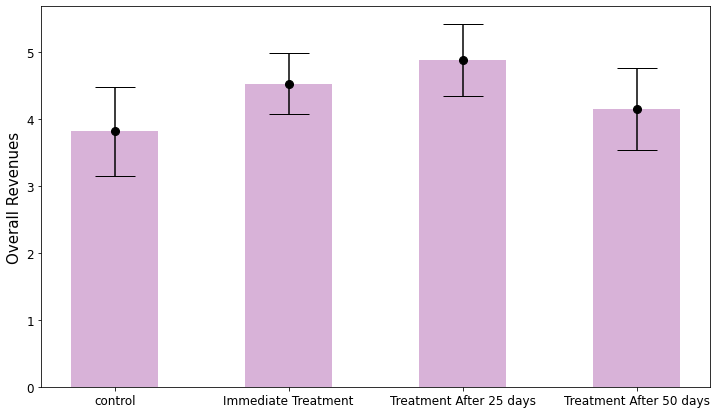

In [36]:
# Create a bar plot with error bar for overall_revenue
# Find out sample mean
overall_revenue_control_mean = control['overall_revenue'].mean()
overall_revenue_0_mean = treatment_after0days['overall_revenue'].mean()
overall_revenue_25_mean = treatment_after25days['overall_revenue'].mean()
overall_revenue_50_mean = treatment_after50days['overall_revenue'].mean()
# Find out standard error
overall_revenue_control_se = se(control['overall_revenue'])
overall_revenue_0_se = se(treatment_after0days['overall_revenue'])
overall_revenue_25_se = se(treatment_after25days['overall_revenue'])
overall_revenue_50_se = se(treatment_after50days['overall_revenue'])

plt.figure(figsize=(12,7))
a = ["control","Immediate Treatment","Treatment After 25 days","Treatment After 50 days"]
b = [overall_revenue_control_mean, overall_revenue_0_mean, overall_revenue_25_mean, overall_revenue_50_mean]
c = [1.96 * overall_revenue_control_se, 1.96*overall_revenue_0_se, 1.96*overall_revenue_25_se,1.96*overall_revenue_50_se]

plt.yticks(fontsize=12)
plt.ylabel("Overall Revenues",fontsize=15)
plt.xticks( fontsize=12)
plt.bar(a, b,color='purple',alpha=0.3, width=0.5)
(_, caps, _) = plt.errorbar(a, b, yerr = c, color = "black",fmt = "o",markersize=8, capsize=20)
for cap in caps:
    cap.set_markeredgewidth(1)



## Treatment Effect Heterogenity

### High_value

In [5]:
lm(df2['high_value'],df2['conversion'])

/Users/wangyahan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     382.3
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           4.85e-85
Time:                        15:40:57   Log-Likelihood:                 7355.9
No. Observations:              160582   AIC:                        -1.471e+04
Df Residuals:                  160580   BIC:                        -1.469e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0453      0.001     55.188      0.000       0.044       0.047
high_value     0.0226      0.001     19.553      0.000       0.020       0.025
==============================================================================
Omnibus:                   121617.549   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1454355.156
Skew:                           3.817   Prob(JB):                         0.00
Kurtosis:                      15.613   Cond. No.                         2.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
model1=smf.ols(formula='conversion ~ treatment + high_value + treatment:high_value',data=df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     77.48
Date:                Mon, 28 Nov 2022   Prob (F-statistic):          9.61e-113
Time:                        15:41:01   Log-Likelihood:                 7435.7
No. Observations:              160582   AIC:                        -1.486e+04
Df Residuals:                  160574   BIC:                        -1.478e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0511      0.001     36.503      0.000       0.048       0.054
treatment[T.after25days]               -0.0052      0.002     -2.586      0.010      -0.009      -0.001
treatment[T.after50days]               -0.0060      0.002     -2.434      0.015      -0.011      -0.001
treatment[T.no_promo]                  -0.0187      0.002     -7.584      0.000      -0.023      -0.014
high_value                              0.0264      0.002     13.392      0.000       0.023       0.030
treatment[T.after25days]:high_value    -0.0051      0.003     -1.827      0.068      -0.011       0.000
treatment[T.after50days]:high_value    -0.0079      0.003     -2.289      0.022      -0.015      -0.001
treatment[T.no_promo]:high_value       -0.0049      0.003     -1.422      0.155      -0.012       0.002
==============================================================================
Omnibus:                   121468.238   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1448957.637
Skew:                           3.811   Prob(JB):                         0.00
Kurtosis:                      15.588   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Mobile Source

In [7]:
model_m=smf.ols(formula='conversion ~ mobile_source',data=df).fit()
model_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     78.20
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.51e-50
Time:                        15:41:15   Log-Likelihood:                 7282.2
No. Observations:              160582   AIC:                        -1.456e+04
Df Residuals:                  160578   BIC:                        -1.452e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0491      0.003     15.003      0.000       0.043       0.056
mobile_source[T.Organic]          -0.0021      0.003     -0.615      0.539      -0.009       0.005
mobile_source[T.Paid]              0.0158      0.003      4.701      0.000       0.009       0.022
mobile_source[T.Wooga Network]     0.0115      0.007      1.670      0.095      -0.002       0.025
==============================================================================
Omnibus:                   121755.782   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1459378.538
Skew:                           3.822   Prob(JB):                         0.00
Kurtosis:                      15.636   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
model_m1=smf.ols(formula='conversion ~ treatment + mobile_source + treatment:mobile_source',data=df).fit()
model_m1.summary()
#the default one is Featuring

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     26.26
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.71e-74
Time:                        15:41:16   Log-Likelihood:                 7361.6
No. Observations:              160582   AIC:                        -1.469e+04
Df Residuals:                  160566   BIC:                        -1.453e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                   0.0540      0.006      9.696      0.000       0.043       0.065
treatment[T.after25days]                                   -0.0017      0.008     -0.212      0.832      -0.017       0.014
treatment[T.after50days]                                   -0.0071      0.010     -0.731      0.465      -0.026       0.012
treatment[T.no_promo]                                      -0.0189      0.010     -1.937      0.053      -0.038       0.000
mobile_source[T.Organic]                                   -0.0004      0.006     -0.074      0.941      -0.012       0.011
mobile_source[T.Paid]                                       0.0198      0.006      3.449      0.001       0.009       0.031
mobile_source[T.Wooga Network]                              0.0103      0.012      0.865      0.387      -0.013       0.034
treatment[T.after25days]:mobile_source[T.Organic]          -0.0048      0.008     -0.574      0.566      -0.021       0.012
treatment[T.after50days]:mobile_source[T.Organic]          -0.0008      0.010     -0.084      0.933      -0.021       0.019
treatment[T.no_promo]:mobile_source[T.Organic]          -7.461e-07      0.010  -7.36e-05      1.000      -0.020       0.020
treatment[T.after25days]:mobile_source[T.Paid]             -0.0073      0.008     -0.879      0.379      -0.023       0.009
treatment[T.after50days]:mobile_source[T.Paid]             -0.0048      0.010     -0.483      0.629      -0.025       0.015
treatment[T.no_promo]:mobile_source[T.Paid]                -0.0045      0.010     -0.444      0.657      -0.024       0.015
treatment[T.after25days]:mobile_source[T.Wooga Network]    -0.0119      0.017     -0.707      0.480      -0.045       0.021
treatment[T.after50days]:mobile_source[T.Wooga Network]     0.0116      0.021      0.566      0.571      -0.029       0.052
treatment[T.no_promo]:mobile_source[T.Wooga Network]        0.0201      0.021      0.960      0.337      -0.021       0.061
==============================================================================
Omnibus:                   121606.493   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1453945.780
Skew:                           3.816   Prob(JB):                         0.00
Kurtosis:                      15.611   Cond. No.                         71.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### days_complete_ch1

In [9]:
model_d=smf.ols(formula='conversion ~ days_complete_ch1',data=df).fit()
model_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     296.1
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           2.64e-66
Time:                        15:41:23   Log-Likelihood:                 7312.9
No. Observations:              160582   AIC:                        -1.462e+04
Df Residuals:                  160580   BIC:                        -1.460e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0611      0.001     96.994      0.000       0.060       0.062
days_complete_ch1    -0.0004   2.57e-05    -17.208      0.000      -0.000      -0.000
==============================================================================
Omnibus:                   121685.446   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1456375.132
Skew:                           3.820   Prob(JB):                         0.00
Kurtosis:                      15.622   Cond. No.                         26.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
model_d1=smf.ols(formula='conversion ~ treatment + days_complete_ch1 + treatment:days_complete_ch1',data=df).fit()
model_d1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     64.93
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           6.61e-94
Time:                        15:41:26   Log-Likelihood:                 7391.9
No. Observations:              160582   AIC:                        -1.477e+04
Df Residuals:                  160574   BIC:                        -1.469e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.0692      0.001     64.206      0.000       0.067       0.071
treatment[T.after25days]                      -0.0076      0.002     -4.951      0.000      -0.011      -0.005
treatment[T.after50days]                      -0.0110      0.002     -5.851      0.000      -0.015      -0.007
treatment[T.no_promo]                         -0.0226      0.002    -11.961      0.000      -0.026      -0.019
days_complete_ch1                             -0.0005   4.42e-05    -11.080      0.000      -0.001      -0.000
treatment[T.after25days]:days_complete_ch1  2.516e-07   6.31e-05      0.004      0.997      -0.000       0.000
treatment[T.after50days]:days_complete_ch1     0.0001   7.63e-05      1.598      0.110   -2.76e-05       0.000
treatment[T.no_promo]:days_complete_ch1        0.0002   7.72e-05      2.042      0.041    6.31e-06       0.000
==============================================================================
Omnibus:                   121537.043   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1450979.955
Skew:                           3.814   Prob(JB):                         0.00
Kurtosis:                      15.596   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Reputation Evaluation

In [ ]:
! pip install google_play_scraper
import pandas as pd
import numpy as np
import re
from google_play_scraper import Sort, reviews


In [ ]:
all_comments = pd.Series(name='content')
ct = 20000
i = 1
continuation_token = None
# for package details, see https://pypi.org/project/google-play-scraper/
while True:
    result, continuation_token = reviews(
        'com.king.candycrushsaga',
        lang='en', 
        country='us', 
        sort=Sort.NEWEST, 
        count=ct,
        continuation_token = continuation_token
    )

    comment = pd.DataFrame(np.array(result),columns=['review'])
    try:
        comment = comment.join(pd.DataFrame(comment.pop('review').tolist())).content
    except:
        print(ct * i, 'records scraped in total')
        comment.to_csv('/datasets/gdrive/comments_last.csv')
        break
        
    comment = comment.loc[comment.str.contains('promo|discount|sale', flags = re.IGNORECASE, na = False)]
    all_comments = pd.concat([all_comments, comment], ignore_index=True)
    print(ct * i, 'records have been scraped')
    i += 1
    print(all_comments.size, 'records include promotion')
    print('current_token:', continuation_token)
    all_comments.to_csv('/datasets/gdrive/comments1.csv')


/tmp/ipykernel_486/3310142618.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_comments = pd.Series(name='content')
20000 records have been scraped
7 records include promotion
current_token: <google_play_scraper.features.reviews._ContinuationToken object at 0x7fc479e1a590>
40000 records have been scraped
14 records include promotion
current_token: <google_play_scraper.features.reviews._ContinuationToken object at 0x7fc47aac47c0>
60000 records have been scraped
18 records include promotion
current_token: <google_play_scraper.features.reviews._ContinuationToken object at 0x7fc47b6df9a0>
80000 records have been scraped
24 records include promotion
current_token: <google_play_scraper.features.reviews._ContinuationToken object at 0x7fc47c0a4b80>
100000 records have been scraped
28 records include promotion
current_token: <google_play_scraper.features.reviews._Cont

In [ ]:
! pip install --upgrade "ibm-watson>=6.1.0"
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 \
    import Features, SentimentOptions

# For more model and api details, please visit IBM docs at https://cloud.ibm.com/apidocs/natural-language-understanding?code=python
authenticator = IAMAuthenticator('{apikey}') # please find apikey at IBM docs, see link above 
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2022-04-07',
    authenticator=authenticator
)

natural_language_understanding.set_service_url("{url}") # please find url at IBM docs, see link above

def get_senti_score(comment_text,promo_words_ls):
    response = natural_language_understanding.analyze(
    text=comment_text,
    features=Features(sentiment=SentimentOptions(targets=promo_words_ls))).get_result()
    return response

def get_cmt_score(sentence):
    sentence_ls = sentence.split(" ")
    #print(sentence_ls)
    words_ls = []
    for word in sentence_ls:
        if re.findall('promo', word, flags=re.IGNORECASE) or re.findall('discount', word, flags=re.IGNORECASE):
            words_ls.append(word)
    res = get_senti_score(sentence, words_ls)
    promo_words_score = []
    for target in res['sentiment']['targets']:
        promo_words_score.append(target['score'])
    return sum(promo_words_score) / len(promo_words_score), res['sentiment']['document']['score']
#get_cmt_score('Thinking about deleting the game for promoting, not discounting')


In [ ]:
df_cmt = pd.read_csv('/datasets/gdrive/comments.csv')
for index, row in df_cmt.iterrows():
    try: # in rare cases, IBM NLU cannot understand the sentence and throw back an error
        res = get_cmt_score(row['content'])
        print('request number', index)
        df_cmt.loc[index, 'promotion_sentiment'] = res[0]
        df_cmt.loc[index, 'sentence_sentiment'] = res[1]
    except:
        print('request number', index, 'failed')
df_cmt.to_csv('/datasets/gdrive/comments_score.csv')

request number 0
request number 1
request number 2
request number 3
request number 4
request number 5
request number 6
request number 7
request number 8
request number 9
request number 10
request number 11
request number 12
request number 13
request number 14
request number 15
request number 16
request number 17
request number 18
request number 19
request number 20
request number 21
request number 22
request number 23
request number 24
request number 25
request number 26
request number 27
request number 28
request number 29
request number 30
request number 31
request number 32
request number 33
request number 34
request number 35
request number 36
request number 37
request number 38
request number 39
request number 40
request number 41
request number 42
request number 43
request number 44
request number 45
request number 46
request number 47
request number 48
request number 49
request number 50
request number 51
request number 52
request number 53
request number 54
request number 55
re

In [ ]:
import matplotlib.pyplot as plt
senti = pd.read_csv('/datasets/gdrive/comments_score.csv')
senti.dropna(how='any', inplace=True)


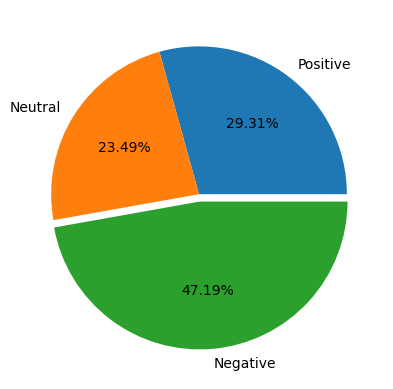

In [ ]:
plt.pie([sum(senti.promotion_sentiment > 0),
         sum(senti.promotion_sentiment == 0), 
         sum(senti.promotion_sentiment < 0)],
        labels=['Positive','Neutral','Negative'],
        explode=(0, 0, 0.05), 
        autopct='%.2f%%'
       )
#plt.title("This is a title")
plt.show()

In [ ]:
import scipy.stats as stats
res = stats.ttest_1samp(senti.promotion_sentiment, popmean=0, alternative='less')
print("t statistic: ", res.statistic)
print("P Value: ", res.pvalue)

t statistic:  -4.761612935113505
P Value:  1.2734615467419492e-06


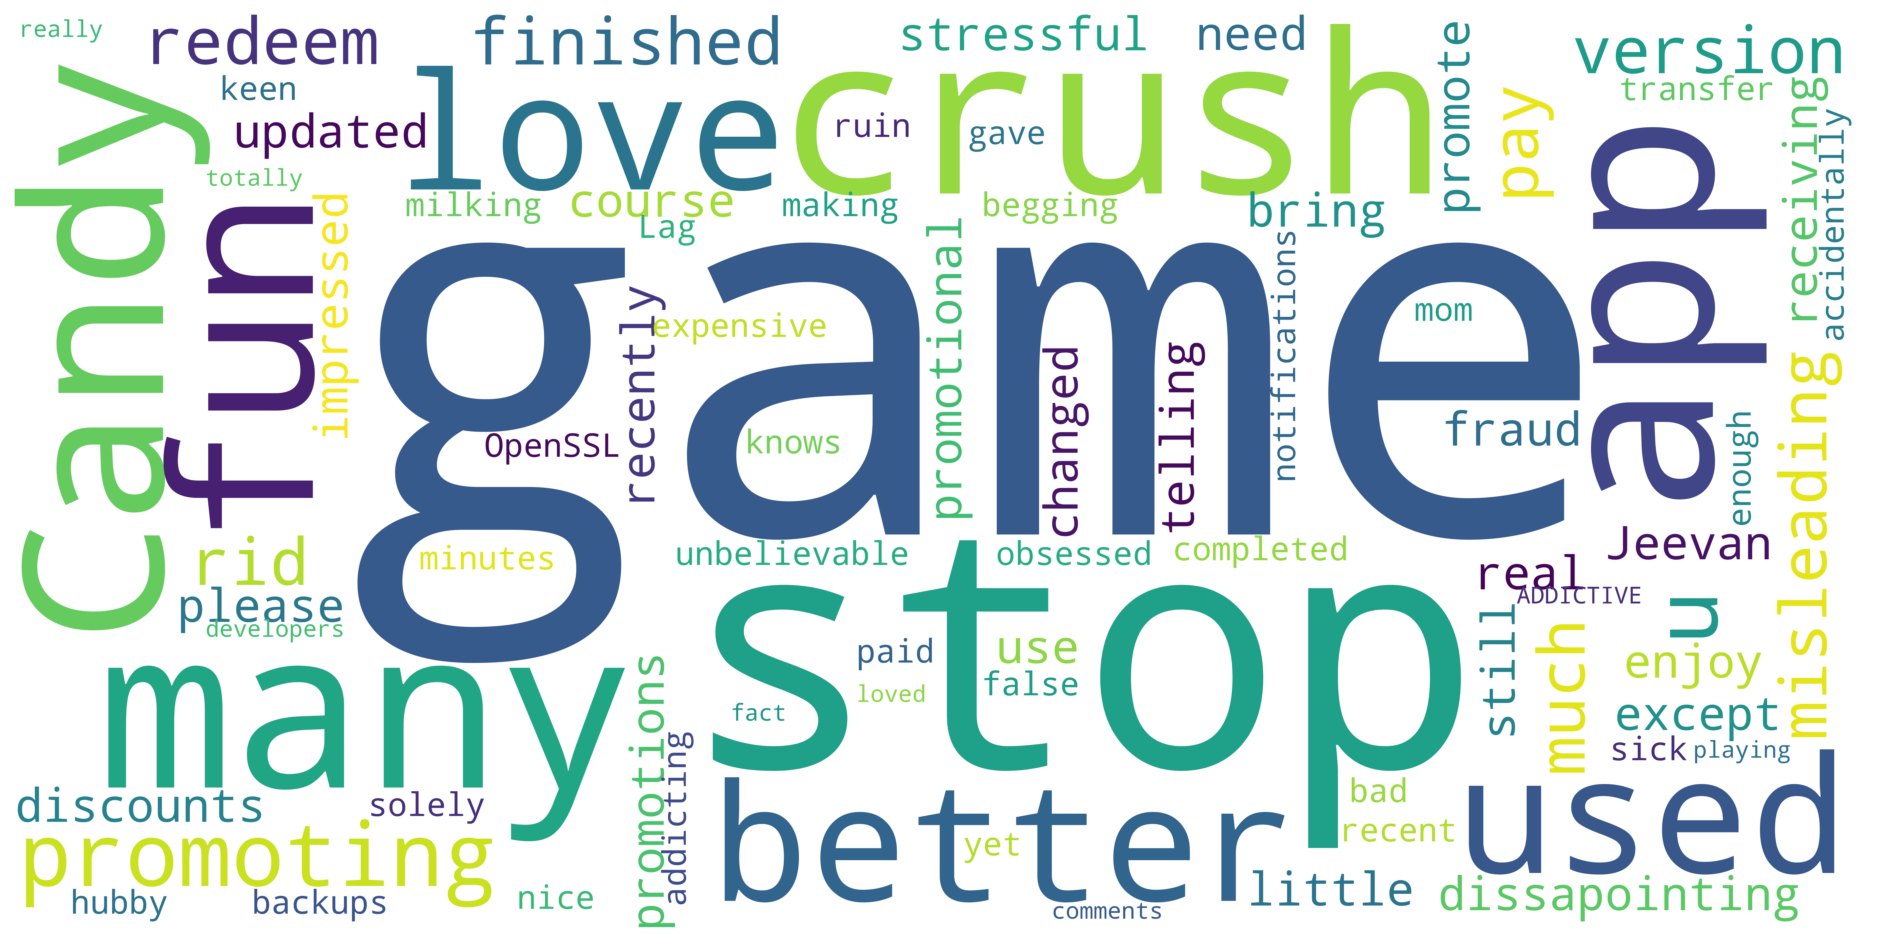

In [ ]:
! pip install wordcloud
from wordcloud import WordCloud
neg_cont = senti.content[(senti.promotion_sentiment < 0) & (senti.sentence_sentiment < 0)]
text = " ".join(cat.split()[1] for cat in neg_cont)
word_cloud = WordCloud(scale=30, collocations = False, background_color = 'white').generate(text)
plt.figure(figsize=(36, 21))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## calibration

In [4]:
all_comments = pd.Series(name='content')
ct = 500
i = 1
continuation_token = None
dataset_size = 0
while dataset_size < 500:
    result, continuation_token = reviews(
        'com.king.candycrushsaga',
        lang='en', # defaults to 'en'
        country='us', # defaults to 'us'
        sort=Sort.NEWEST, # defaults to Sort.NEWEST
        count=ct, # defaults to 100
        continuation_token = continuation_token
        #filter_score_with=5 # defaults to None(means all score)
    )

    comment = pd.DataFrame(np.array(result),columns=['review'])
    try:
        comment = comment.join(pd.DataFrame(comment.pop('review').tolist())).content
    except:
        print(ct * i, 'records scraped in total')
        comment.to_csv('/datasets/gdrive/comments_game_last.csv')
        break
        
    comment = comment.loc[comment.str.contains('game|gaming', flags = re.IGNORECASE, na = False)]
    all_comments = pd.concat([all_comments, comment], ignore_index=True)
    print(ct * i, 'records have been scraped')
    i += 1
    dataset_size = all_comments.size
    print(dataset_size, 'records include game')
    all_comments.to_csv('/datasets/gdrive/comments_game.csv')


/tmp/ipykernel_75/1435571479.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_comments = pd.Series(name='content')
500 records have been scraped
171 records include game
1000 records have been scraped
342 records include game
1500 records have been scraped
505 records include game


In [38]:
def get_game_score(sentence):
    sentence_ls = sentence.split(" ")
    #print(sentence_ls)
    words_ls = []
    for word in sentence_ls:
        if re.findall('game', word, flags=re.IGNORECASE) or re.findall('gaming', word, flags=re.IGNORECASE):
            words_ls.append(word)
    res = get_senti_score(sentence, words_ls)
    words_score = []
    for target in res['sentiment']['targets']:
        words_score.append(target['score'])
    return sum(words_score) / len(words_score), res['sentiment']['document']['score']

#get_game_score('it is a really bad game')

In [19]:
df_game_cmt = pd.read_csv('/datasets/gdrive/comments_game.csv')
for index, row in df_game_cmt.iterrows():
    try: # in rare cases, IBM NLU cannot understand the sentence and throw back an error
        res = get_game_score(row['content'])
        print('request number', index)
        df_game_cmt.loc[index, 'game_sentiment'] = res[0]
        df_game_cmt.loc[index, 'sentence_sentiment'] = res[1]
    except:
        print('request number', index, 'failed')
df_game_cmt.to_csv('/datasets/gdrive/comments_game_score.csv')

request number 0
request number 1
request number 2
request number 3
request number 4
request number 5
request number 6
request number 7
request number 8
request number 9 failed
request number 10
request number 11 failed
request number 12 failed
request number 13
request number 14 failed
request number 15
request number 16
request number 17
request number 18
request number 19
request number 20
request number 21 failed
request number 22 failed
request number 23
request number 24
request number 25
request number 26
request number 27
request number 28
request number 29
request number 30
request number 31 failed
request number 32
request number 33
request number 34
request number 35
request number 36
request number 37
request number 38 failed
request number 39
request number 40
request number 41 failed
request number 42
request number 43
request number 44
request number 45 failed
request number 46 failed
request number 47
request number 48
request number 49
request number 50
request number 

In [64]:
# Average sentiment score for game word in all reviews
avg_game_senti = df_game_cmt.dropna().game_sentiment.mean()
avg_game_senti

0.5802626590524534

In [20]:
game_comment = pd.read_csv('/datasets/gdrive/comments_score.csv').content
game_comment = game_comment.loc[game_comment.str.contains('game|gaming', flags = re.IGNORECASE, na = False)]

In [35]:
df_game_comment = pd.DataFrame(game_comment)
for index, row in df_game_comment.iterrows():
    try: # in rare cases, IBM NLU cannot understand the sentence and throw back an error
        res = get_game_score(row['content'])
        print('request number', index)
        df_game_comment.loc[index, 'game_sentiment'] = res[0]
        df_game_comment.loc[index, 'sentence_sentiment'] = res[1]
    except:
        print('request number', index, 'failed')
df_game_comment.to_csv('/datasets/gdrive/comments_promo_game_score.csv')

request number 1
request number 3
request number 5
request number 7
request number 8
request number 10
request number 13
request number 14
request number 16
request number 17
request number 18
request number 19
request number 21
request number 28
request number 30
request number 31
request number 33
request number 35
request number 36
request number 39
request number 41
request number 43
request number 45
request number 47
request number 49
request number 53
request number 54
request number 58
request number 59
request number 60
request number 62
request number 65
request number 68
request number 69
request number 70
request number 71
request number 72
request number 75
request number 76
request number 78
request number 80
request number 83
request number 84
request number 85
request number 87
request number 88
request number 92
request number 95
request number 96
request number 97
request number 99
request number 100
request number 101
request number 102
request number 103
request num

In [65]:
# Average sentiment score for game word in promo-related reviews only
avg_game_score_promo_only = df_game_comment.game_sentiment.mean()
avg_game_score_promo_only

-0.003587045852229773

In [60]:
df_promo_comment = pd.read_csv('/datasets/gdrive/comments_score.csv')
df_promo_comment.dropna(how='any', inplace=True)
df_promo_comment['calibrated_sentiment'] = (df_promo_comment.promotion_sentiment - \
                                            avg_game_senti) / avg_game_senti
df_promo_comment.to_csv('/datasets/gdrive/promo_related_comments_calibrated.csv')

### show the calibrated scores

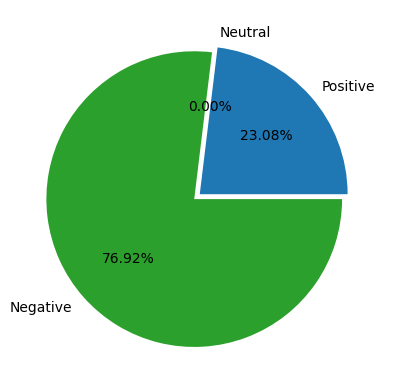

In [47]:
plt.pie([sum(df_promo_comment.calibrated_sentiment > 0),
         sum(df_promo_comment.calibrated_sentiment == 0), 
         sum(df_promo_comment.calibrated_sentiment < 0)],
        labels=['Positive','Neutral','Negative'],
        #colors=["#9400D3", "#4B0082", "#8B008B"], 
        explode=(0, 0, 0.05), 
        autopct='%.2f%%'
       )
#plt.title("This is a title")
plt.show()

In [49]:
import scipy.stats as stats
res = stats.ttest_1samp(df_promo_comment.calibrated_sentiment, popmean=0, alternative='less')
print("t statistic: ", res.statistic)
print("P Value: ", res.pvalue)

t statistic:  -23.444828835064726
P Value:  7.029992137216944e-82


In [53]:
#! pip install researchpy
import researchpy as rp
rp.ttest(group1 = df_game_cmt.game_sentiment, group1_name = 'sentiment score for game in all review',
         group2 = df_game_comment.game_sentiment,group2_name = 'sentiment score for game in promo-related reviews')

(                                            Variable      N      Mean  \
 0             sentiment score for game in all review  394.0  0.580263   
 1  sentiment score for game in promo-related reviews  252.0 -0.003587   
 2                                           combined  646.0  0.352507   
 
          SD        SE  95% Conf.  Interval  
 0  0.679706  0.034243   0.512940  0.647585  
 1  0.735313  0.046320  -0.094813  0.087639  
 2  0.757055  0.029786   0.294018  0.410996  ,
                                   Independent t-test   results
 0  Difference (sentiment score for game in all re...    0.5838
 1                              Degrees of freedom =   644.0000
 2                                               t =    10.3123
 3                           Two side test p value =     0.0000
 4                          Difference < 0 p value =     1.0000
 5                          Difference > 0 p value =     0.0000
 6                                       Cohen's d =     0.8318
 7   

In [50]:
df_game_comment

,content,game_sentiment,sentence_sentiment
1,Game is good but prompts for more ads. Here th...,0.825853,-0.764869
3,Bloody ads in other apps... Very cheap promoti...,-0.979727,-0.735461
5,No long enjoyable on my laptop. I play this on...,0.747242,0.476905
7,"It used to be lovely game, but now it has a lo...",-0.480953,-0.762725
8,Fun game but very annoying some time Keep prom...,-0.951409,-0.940606
...,...,...,...
481,"Good game, but the lives system ruins it. The ...",-0.369176,-0.369176
483,This game is by far one the sweetest pass time...,0.733101,0.837895
484,"Fun game, but I hate that if you run out of li...",0.671480,0.737658
485,"no comments on lives n game play, but on the i...",-0.411712,-0.691750


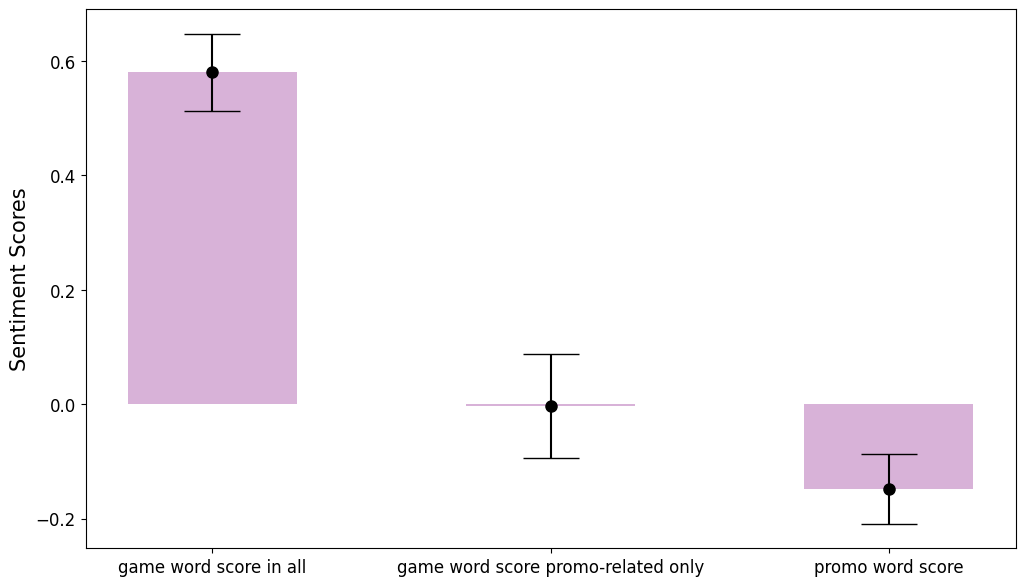

In [67]:
# compare the difference between game scores in all reviews and in promo-related reviews and promo word score 
avg_promo_score = df_promo_comment.promotion_sentiment.mean()

# Find out standard error
all_ct = df_game_cmt.game_sentiment.count()
promo_ct = df_game_comment.game_sentiment.count()
promo_word_ct = df_promo_comment.promotion_sentiment.count()

all_sd = df_game_cmt.game_sentiment.std()
promo_sd = df_game_comment.game_sentiment.std()
promo_word_sd = df_promo_comment.promotion_sentiment.std()

all_se = all_sd / all_ct**0.5
promo_se = promo_sd / promo_ct ** 0.5
promo_word_se = promo_word_sd / promo_word_ct** 0.5

plt.figure(figsize=(12,7))
a = ["game word score in all","game word score promo-related only", 'promo word score']
b = [avg_game_senti, avg_game_score_promo_only, avg_promo_score]
plt.yticks(fontsize=12)
plt.ylabel("Sentiment Scores",fontsize=15)
plt.xticks( fontsize=12)
plt.bar(a, b,color='purple',alpha=0.3, width=0.5)
c = [1.96 * all_se, 1.96*promo_se, 1.96*promo_word_se]
(_, caps, _) = plt.errorbar(a, b, yerr = c, color = "black",fmt = "o",markersize=8, capsize=20)
for cap in caps:
    cap.set_markeredgewidth(1)
